In [278]:
# pip install mpltern

In [280]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np
import mpltern

from mpl_toolkits.mplot3d import Axes3D

In [282]:
"""
check errors in the code:
- Q value updating
- updating of message distribution

"""

'\ncheck errors in the code:\n- Q value updating\n- updating of message distribution\n\n'

In [284]:
"""
there's something that does not work in the updating of the message distribution
"""

"\nthere's something that does not work in the updating of the message distribution\n"

In [286]:
def social_welfare_function(payoffs, mixed_strategies):
    """
    Compute the social welfare of a given strategy profile.

    Parameters:
        payoffs (list): A 2x2 matrix of payoffs for all players.
                        payoffs[0] contains the payoffs for player 1, and
                        payoffs[1] contains the payoffs for player 2.
        mixed_strategies (list): List of mixed strategies for both players.

    Returns:
        float: Social welfare value.
    """
    # Extract mixed strategies for both players
    x1 = mixed_strategies[0]  # Player 1's mixed strategy
    x2 = mixed_strategies[1]  # Player 2's mixed strategy

    # Calculate the social welfare
    social_welfare = 0
    num_actions = len(x1)
    # num_actions = 2

    for a1 in range(num_actions):
        for a2 in range(num_actions):
            # Probability of (a1, a2) being played
            prob = x1[a1] * x2[a2]
            # Payoffs for both players at (a1, a2)
            u1 = payoffs[0][a1][a2]
            u2 = payoffs[1][a2][a1]
            # Add the total payoff to the social welfare
            social_welfare += prob * (u1 + u2)

    return social_welfare

In [288]:
# need to define a set of messages and a partition for each player

# message set: M = {m1,m2,m3,m4}
# partition of P1: PM1 = {{m1,m2},{m3,m4}}
# partition of P2: PM2 = {{m1,m3},{m2,m4}}

# the Q-values are conditional on the element of the partition

# how to update the message distribution? 
# evaluate the value of a message as the utilitarian aggregation of the mixed strategies induced by its partitions 

In [290]:
# new input

# messages = ['m1', 'm2', 'm3', 'm4']

# partitions = [partition_1, partition_2]

# define a Q-value for each element of the partition

In [292]:
# you still evaluate the social welfare, but the mixed strategies you enter in the evaluations are not conditional on messages
# they are conditional on one element of the partition

# the evaluation of the social welfare is the same as before


def social_welfare_function(payoffs, mixed_strategies):
    """
    Compute the social welfare of a given strategy profile.

    Parameters:
        payoffs (list): A 2x2 matrix of payoffs for all players.
                        payoffs[0] contains the payoffs for player 1, and
                        payoffs[1] contains the payoffs for player 2.
        mixed_strategies (list): List of mixed strategies for both players.

    Returns:
        float: Social welfare value.
    """
    # Extract mixed strategies for both players
    x1 = mixed_strategies[0]  # Player 1's mixed strategy
    x2 = mixed_strategies[1]  # Player 2's mixed strategy

    # Calculate the social welfare
    social_welfare = 0
    num_actions = len(x1)
    # num_actions = 2

    for a1 in range(num_actions):
        for a2 in range(num_actions):
            # Probability of (a1, a2) being played
            prob = x1[a1] * x2[a2]
            # Payoffs for both players at (a1, a2)
            u1 = payoffs[0][a1][a2]
            u2 = payoffs[1][a2][a1]
            # Add the total payoff to the social welfare
            social_welfare += prob * (u1 + u2)

    return social_welfare

In [294]:
def q_learning_with_partitions(
    payoffs, T, alpha, beta0, k, messages, initial_message_probabilities, welfare_function, partitions
):
    """
    Q-learning algorithm for a finite 2x2 game with social welfare and adaptive message probabilities.
    Q-values are conditional on elements of partitions of the message set for each player.

    Parameters:
        payoffs: Payoff matrix (list of 2x2 arrays).
        T: Number of iterations.
        alpha: Learning rate.
        beta0: Initial softmax parameter.
        k: Softmax parameter growth rate.
        messages: List of messages.
        initial_message_probabilities: Initial probabilities for messages.
        welfare_function: Function to calculate social welfare.
        partitions: List of partitions, one for each player (e.g., [{...}, {...}]).

    Outputs:
    - last iterate correlated strategy
    - last iterate social welfare
    - last iterate message probability
    - frequency of play
    - action history
    - average mixed strategies
    - conditional last iterate mixed strategies
    - social welfare over time
    """
    num_players = 2
    num_actions = 2
    num_messages = len(messages)

    if len(initial_message_probabilities) != num_messages:
        raise ValueError(f"Initial message probabilities must match the number of messages. "
                         f"Expected length {num_messages}, got {len(initial_message_probabilities)}.")

    if len(partitions) != num_players:
        raise ValueError(f"Partitions must be provided for each player. Expected {num_players}, got {len(partitions)}.")

    # Map each message to its partition element for each player
    message_to_partition = [
        {message: partition for partition in partitions[i] for message in partitions[i][partition]}
        for i in range(num_players)
    ]

    # Initialize Q-values for all players and partition elements
    Q = [
        {partition: np.zeros(num_actions) for partition in partitions[i]}
        for i in range(num_players)
    ]
    message_probabilities = np.array(initial_message_probabilities)
    W = np.zeros(num_messages)
    
    # Track data
    strategies = {partition: [np.array([0.5, 0.5]) for _ in range(num_players)] for i in range(num_players) for partition in partitions[i]}
    action_counts = {partition: [np.zeros(num_actions) for _ in range(num_players)] for i in range(num_players) for partition in partitions[i]}
    action_history = [[] for _ in range(num_players)]
    conditional_strategies_history = {partition: [] for i in range(num_players) for partition in partitions[i]}
    correlated_strategy_history = []
    social_welfare = 0
    social_welfare_history = []
    message_probabilities_history = []

    action_profiles = [(0, 0), (0, 1), (1, 0), (1, 1)]
    correlated_strategy = {profile: 0 for profile in action_profiles}

    for t in range(1, T + 1):
        beta = beta0 + k * t
        # Sample a message based on probabilities
        message = np.random.choice(messages, p=message_probabilities)

        # Get the partition element for each player
        partitions_for_message = [message_to_partition[i][message] for i in range(num_players)]
        mixed_strategies = []

        # Compute mixed strategies and  strategies (KEY MODIFICATION)

        for i in range(num_players):
            partition_for_player = partitions_for_message[i]  # Get the partition element for player i
            mixed_strategy = np.exp(beta * Q[i][partition_for_player]) / np.sum(np.exp(beta * Q[i][partition_for_player]))
            mixed_strategies.append(mixed_strategy)

        # Update the strategy corresponding to the partition for each player
        for i in range(num_players):
            partition_for_player = partitions_for_message[i]  # Get the partition element for player i
            strategies[partition_for_player][i] = mixed_strategies[i]
        
        # Save current conditional mixed strategies
        for i in range(num_players):
            conditional_strategies_history[partitions_for_message[i]].append(mixed_strategies[i].copy())

        # Sample actions
        actions = [np.random.choice(num_actions, p=mixed_strategies[i]) for i in range(num_players)]
        for i in range(num_players):
            action_history[i].append(actions[i])
            action_counts[partitions_for_message[i]][i][actions[i]] += 1

        # Compute payoffs
        rewards = [payoffs[i][actions[i]][actions[1 - i]] for i in range(num_players)]
        rewards_counterf = [payoffs[i][1 - actions[i]][actions[1 - i]] for i in range(num_players)]

        # Update Q-values
        for i in range(num_players):
            Q[i][partitions_for_message[i]][actions[i]] = (1 - alpha) * Q[i][partitions_for_message[i]][actions[i]] + rewards[i]
            Q[i][partitions_for_message[i]][1 - actions[i]] = (1 - alpha) * Q[i][partitions_for_message[i]][1-actions[i]] + rewards_counterf[i]


        # Compute social welfare (KEY MODIFICATION)
        social_welfares = {}
        for m in messages:
            # Identify the partition elements for the message `m` for each player
            partition_elements = [
                next(group for group, msgs in partitions[i].items() if m in msgs)
                for i in range(num_players)
            ]
    
            # Retrieve the latest strategies corresponding to the partition elements
            latest_strategy = [
                strategies[partition_elements[i]][i]  # Strategy of player `i` for their partition element
                for i in range(num_players)
            ]
    
            # Compute the social welfare for the message `m`
            social_welfares[m] = welfare_function(payoffs, latest_strategy)

        # Update message probabilities
        k1 = 0.01
        a1 = 0.4
        b1 = beta0 + k1*t
        social_welfare_values = np.array(list(social_welfares.values()))
        if np.sum(social_welfare_values) == 0:
            social_welfare_values += 1e-6

        for i in range(num_messages):
            W[i] = (1-a1) * W[i] + social_welfare_values[i]
        
        exp_values = np.exp(b1 * W)
        #exp_values = np.exp(b1 * social_welfare_values)
        
        message_probabilities = exp_values / np.sum(exp_values)
        message_probabilities_history.append(message_probabilities)

        # message_probabilities = social_welfare_values / np.sum(social_welfare_values)
        # message_probabilities_history.append(message_probabilities)

        # Update correlated strategy
        correlated_strategy = {profile: 0 for profile in action_profiles}

        for m, prob_m in zip(messages, message_probabilities):
            # Find the partition elements for both players
            partition_elements = [
                next(group for group, msgs in partitions[i].items() if m in msgs)  # Find the partition for player i
                for i in range(num_players)
            ]
    
                # Use the partition elements to access the strategies for the corresponding partitions
            for i in range(num_players):
                # Get the strategies for the partition element corresponding to player i
                partition = partition_elements[i]
                mixed_strategy = strategies[partition][i]  # Strategies are now indexed by the partition element, not by message m
        
            for a1 in range(num_actions):
                for a2 in range(num_actions):
                    profile = (a1, a2)
                    # Update the correlated strategy using the partitioned strategies
                    correlated_strategy[profile] += prob_m * mixed_strategy[a1] * mixed_strategy[a2]

                    total_probability = sum(correlated_strategy.values())
        for profile in correlated_strategy:
            correlated_strategy[profile] /= total_probability

             # Save correlated strategy and compute social welfare of correlated strategy
        correlated_strategy_snapshot = correlated_strategy.copy()
        correlated_strategy_history.append(correlated_strategy_snapshot)
        for m, prob_m in zip(messages, message_probabilities):
            social_welfare += prob_m * social_welfares[m]
        social_welfare_history.append(social_welfare)
        social_welfare = 0

        """
        # these are conditioned on messages, not good for this code
        # modify to condition on partition elements

        # Compute averages
        avg_mixed_strategies = {
            message: [
                np.mean([strategies[message][i]], axis=0)
                for i in range(num_players)
            ]
            for message in messages
        }

        last_iterate_strategies = {
            message: [strategies[message][i] for i in range(num_players)]
            for message in messages
        }

        frequencies = {
            message: [counts / T for counts in action_counts[message]]
            for message in messages
        }
        """

    return {
        # "last_iterate": last_iterate_strategies,
        # "average_mixed_strategy": avg_mixed_strategies,
        "adaptive_message_probabilities": message_probabilities,
        "correlated_strategy": correlated_strategy,
        "correlated_strategy_history": correlated_strategy_history,
        "conditional_strategies_history": conditional_strategies_history,
        "message_probabilities_history": message_probabilities_history,
        "social_welfare_history": social_welfare_history,
        # "frequency_of_play": frequencies,
        "action_history": action_history
    }

In [296]:
# Example 2x2 game payoffs (HD game):
"""
payoffs = [
    [[5, 2], [7, 1]],  # Payoffs for Player 0
    [[5, 2], [7, 1]]   # Payoffs for Player 1
]
"""

# Example 2x2 game payoffs (Coordination game):
payoffs = [
    [[0, 1], [2, 0]],  # Payoffs for Player 0
    [[0, 2], [1, 0]]   # Payoffs for Player 1
]

"""
# Example 2x2 game payoffs (Prisoner dilemma):
payoffs = [
    [[2, 0], [5, 0]],  # Payoffs for Player 0
    [[2, 0], [5, 0]]   # Payoffs for Player 1
]
"""
# pick a game at random

"""
payoffs = [
    [[random.randint(0, 10), random.randint(0, 10)], [random.randint(0, 10), random.randint(0, 10)]],  # Payoffs for Player 0
    [[random.randint(0, 10), random.randint(0, 10)], [random.randint(0, 10), random.randint(0, 10)]]   # Payoffs for Player 1
]
"""

'\npayoffs = [\n    [[random.randint(0, 10), random.randint(0, 10)], [random.randint(0, 10), random.randint(0, 10)]],  # Payoffs for Player 0\n    [[random.randint(0, 10), random.randint(0, 10)], [random.randint(0, 10), random.randint(0, 10)]]   # Payoffs for Player 1\n]\n'

In [298]:
payoffs

[[[0, 1], [2, 0]], [[0, 2], [1, 0]]]

In [300]:
"""
payoffs = [[[9, 9], [2, 7]], [[5, 4], [2, 7]]]
payoffs = [[[7, 7], [8, 3]], [[2, 8], [1, 8]]]
"""

'\npayoffs = [[[9, 9], [2, 7]], [[5, 4], [2, 7]]]\npayoffs = [[[7, 7], [8, 3]], [[2, 8], [1, 8]]]\n'

In [302]:
# Message set
messages = ["m1", "m2", "m3", "m4"]

# Partitions for each player
# Player 0 groups messages into two sets: {"m1", "m2"} and {"m3", "m4"}
# Player 1 groups messages into two sets: {"m1", "m3"} and {"m2", "m4"}
partitions = [
    {  # Partition for Player 0
        "group_0": {"m1", "m2"},
        "group_1": {"m3", "m4"}
    },
    {  # Partition for Player 1
        "group_0": {"m1", "m3"},
        "group_1": {"m2", "m4"}
    }
]

# Initial message probabilities
initial_message_probabilities = [0.25, 0.25, 0.25, 0.25]  # Uniform probabilities

In [304]:
# Parameters
T = 1000
alpha = 0.3
beta0 = 0.01
k = 0.01

In [306]:
# Run the Q-learning algorithm
results = q_learning_with_partitions(
    payoffs, T, alpha, beta0, k, messages, initial_message_probabilities, social_welfare_function, partitions
)

# Display results# print("Last iterate mixed strategies (by message):", results["last_iterate"])
print("Adaptive message probabilities:", results["adaptive_message_probabilities"])
print("Last iterated correlated strategy:", results["correlated_strategy"])
# print("Social welfare:", results["social_welfare_weighted_last"])

Adaptive message probabilities: [0.25 0.25 0.25 0.25]
Last iterated correlated strategy: {(0, 0): 1.0, (0, 1): 1.0784481930008141e-29, (1, 0): 1.0784481930008141e-29, (1, 1): 1.164341826684741e-58}


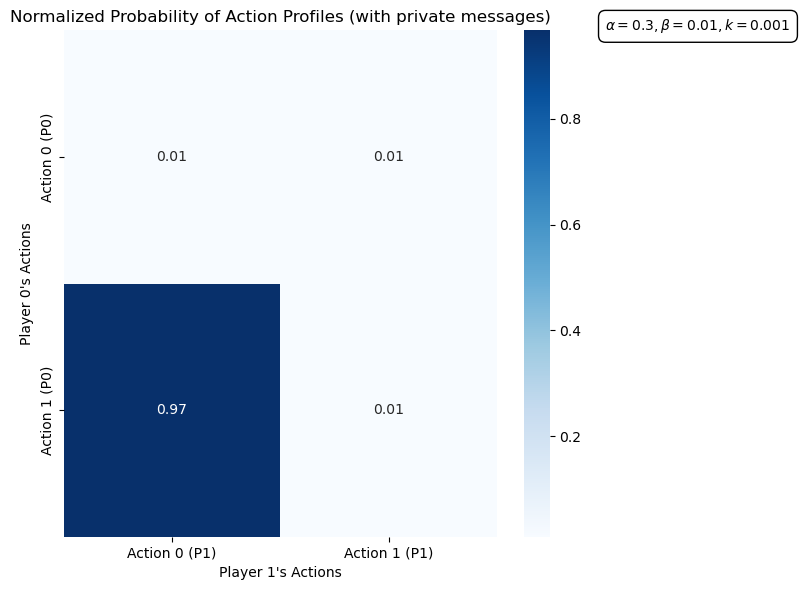

In [308]:
# Extract action history
action_history_0 = results["action_history"][0]  # Player 0's actions
action_history_1 = results["action_history"][1]  # Player 1's actions

# Compute the frequency matrix for action profiles [a_0, a_1]
num_actions = 2  # Assuming binary actions (0 and 1)
frequency_matrix = np.zeros((num_actions, num_actions), dtype=int)

# Count occurrences of each action profile
for a0, a1 in zip(action_history_0, action_history_1):
    frequency_matrix[a0, a1] += 1

# Normalize the frequency matrix to get probabilities
frequency_matrix_prob = frequency_matrix / np.sum(frequency_matrix)

# Plot the normalized frequency matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    frequency_matrix_prob, 
    annot=True, 
    fmt=".2f", 
    cmap="Blues", 
    xticklabels=["Action 0 (P1)", "Action 1 (P1)"],
    yticklabels=["Action 0 (P0)", "Action 1 (P0)"]
)
plt.title("Normalized Probability of Action Profiles (with private messages)")
plt.xlabel("Player 1's Actions")
plt.ylabel("Player 0's Actions")

plt.text(
    2.5, 0,   # Coordinates for the text box (adjust based on your plot)
    r"$\alpha = 0.3, \beta = 0.01, k = 0.001$", 
    fontsize=10, 
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5')
)

plt.tight_layout()

plt.savefig("/Users/franc/Dropbox/ML project/code/images_fra/frequency_Coordination_private_msg.png")

plt.show()

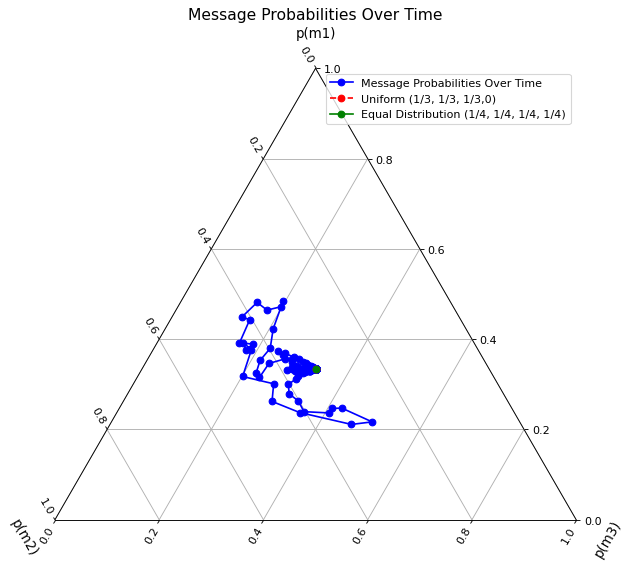

In [310]:
# Assuming message_probabilities_history is available as the input
message_probabilities_history = results["message_probabilities_history"]

# Extract the probability history for messages m1, m2, and m3
# We assume each entry is a list of probabilities like [p_m1, p_m2, p_m3]
proba_history = np.array(message_probabilities_history)  # Shape: (iterations, 3)

# Create a ternary plot
fig, ax = plt.subplots(figsize=(8, 8), dpi=80, subplot_kw={'projection': 'ternary'})

# Plot the probability points over time
ax.plot(proba_history[:, 0], proba_history[:, 1], proba_history[:, 2], marker='o', linestyle='-', color="blue", label="Message Probabilities Over Time")

# Plot the first set of constant probabilities (1/3, 1/3, 1/3) with a dashed red line
ax.plot(0.33, 0.33, 0.33, marker='o', linestyle='--', color="red", label="Uniform (1/3, 1/3, 1/3,0)")

# Plot the second set of constant probabilities (1/4, 1/4, 1/4, 1/4) with a green line
ax.plot(0.25, 0.25, 0.25, marker='o', linestyle='-', color="green", label="Equal Distribution (1/4, 1/4, 1/4, 1/4)")

# Title and labels for the ternary plot
ax.set_title("Message Probabilities Over Time", fontsize=14)
ax.set_tlabel("p(m1)", fontsize=12)
ax.set_llabel("p(m2)", fontsize=12)
ax.set_rlabel("p(m3)", fontsize=12)

# Add grid
ax.grid(True)

# Add legend
ax.legend()

plt.tight_layout()

plt.savefig("/Users/franc/Dropbox/ML project/code/images_fra/message_proba_Coordination_private_msg.png")


# Show plot
plt.show()

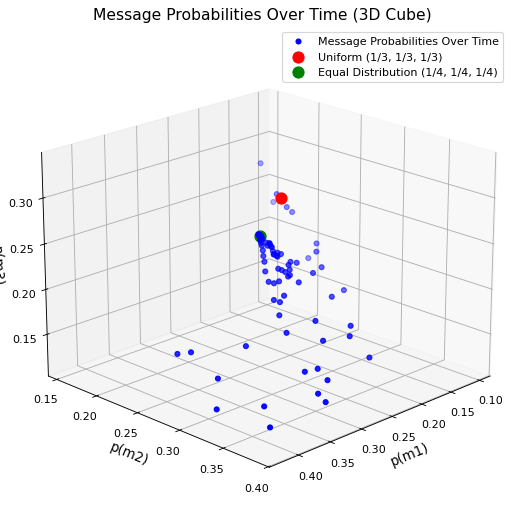

In [311]:
# Assuming message_probabilities_history is available as the input
message_probabilities_history = results["message_probabilities_history"]

# Extract the probability history for messages m1, m2, m3, and m4
# We assume each entry is a list of probabilities like [p_m1, p_m2, p_m3, p_m4]
proba_history = np.array(message_probabilities_history)  # Shape: (iterations, 4)

# Normalize the probabilities for ternary plot (using m1, m2, m3 for the 3D plot)
# Here, we assume the probabilities already sum to 1, but if not, we normalize them
normalized_probs = proba_history[:, :3]  # Only using the first three messages (m1, m2, m3) for the plot

# Create a 3D scatter plot
fig = plt.figure(figsize=(8, 8), dpi=80)
ax = fig.add_subplot(111, projection='3d')

# Plot the probability points over time
ax.scatter(normalized_probs[:, 0], normalized_probs[:, 1], normalized_probs[:, 2], c='blue', marker='o', label="Message Probabilities Over Time")

# Plot the first set of constant probabilities (1/3, 1/3, 1/3) with a dashed red line
ax.scatter(1/3, 1/3, 1/3, color="red", marker='o', s=100, label="Uniform (1/3, 1/3, 1/3)")

# Plot the second set of constant probabilities (1/4, 1/4, 1/4) with a green point
ax.scatter(1/4, 1/4, 1/4, color="green", marker='o', s=100, label="Equal Distribution (1/4, 1/4, 1/4)")

# Title and labels for the 3D plot
ax.set_title("Message Probabilities Over Time (3D Cube)", fontsize=14)
ax.set_xlabel("p(m1)", fontsize=12)
ax.set_ylabel("p(m2)", fontsize=12)
ax.set_zlabel("p(m3)", fontsize=12)

# Add grid
ax.grid(True)

# Add legend
ax.legend()

# Rotate the plot to get a better view
ax.view_init(elev=20, azim=45)  # Adjust these values for desired rotation

plt.savefig("/Users/franc/Dropbox/ML project/code/images_fra/message_proba_1_Coordination_private_msg.png")

# Show plot
plt.show()

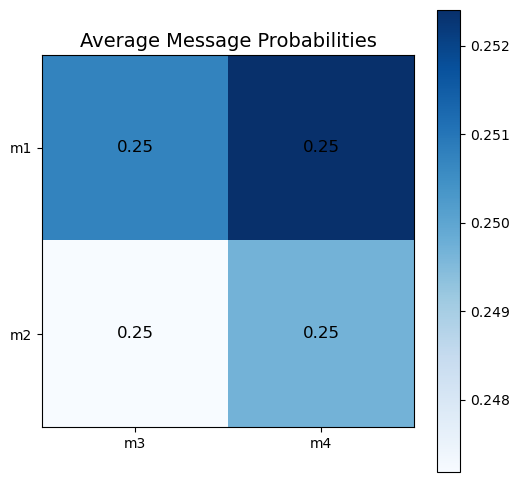

In [312]:
message_probabilities_history = results["message_probabilities_history"]

# Convert message_probabilities_history to a NumPy array
proba_history = np.array(message_probabilities_history)  # Shape: (iterations, 4)

# Compute the average of each probability across all iterations for messages m1, m2, m3, m4
average_probs = np.mean(proba_history, axis=0)

# Reshape the average probabilities into a 2x2 matrix for better visualization
matrix = average_probs.reshape(2, 2)

# Plotting the matrix
fig, ax = plt.subplots(figsize=(6, 6))

# Use imshow to plot the matrix
cax = ax.imshow(matrix, cmap='Blues', interpolation='nearest')

# Add color bar to show the probability scale
fig.colorbar(cax)

# Title and axis labels
ax.set_title("Average Message Probabilities", fontsize=14)
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(['m3', 'm4'])
ax.set_yticklabels(['m1', 'm2'])

# Annotate each cell with the corresponding average probability
for i in range(2):
    for j in range(2):
        ax.text(j, i, f'{matrix[i, j]:.2f}', ha='center', va='center', fontsize=12, color='black')


plt.savefig("/Users/franc/Dropbox/ML project/code/images_fra/average_message_proba_Coordination_private_msg.png")

plt.show()

In [313]:
message_probabilities_history

[array([0.25, 0.25, 0.25, 0.25]),
 array([0.24997188, 0.24997188, 0.25002812, 0.25002812]),
 array([0.25015415, 0.24993862, 0.25005354, 0.24985369]),
 array([0.25069464, 0.24988665, 0.25004891, 0.2493698 ]),
 array([0.25094571, 0.25013575, 0.24979655, 0.24912199]),
 array([0.25131958, 0.24985602, 0.2500506 , 0.24877379]),
 array([0.25149476, 0.2491741 , 0.25078342, 0.24854772]),
 array([0.25101874, 0.24873132, 0.25131258, 0.24893736]),
 array([0.25068836, 0.24909715, 0.25093246, 0.24928203]),
 array([0.25019613, 0.25032775, 0.24977513, 0.24970099]),
 array([0.24992715, 0.25014854, 0.24991385, 0.25001046]),
 array([0.25014845, 0.25278025, 0.24772752, 0.24934379]),
 array([0.25005433, 0.25727331, 0.24455213, 0.24812024]),
 array([0.25173682, 0.25991171, 0.24237964, 0.24597182]),
 array([0.25196408, 0.26649416, 0.23850889, 0.24303287]),
 array([0.25454392, 0.26913422, 0.23619636, 0.24012551]),
 array([0.25308668, 0.27261292, 0.23452083, 0.23977956]),
 array([0.25326271, 0.2686879 , 0.2363

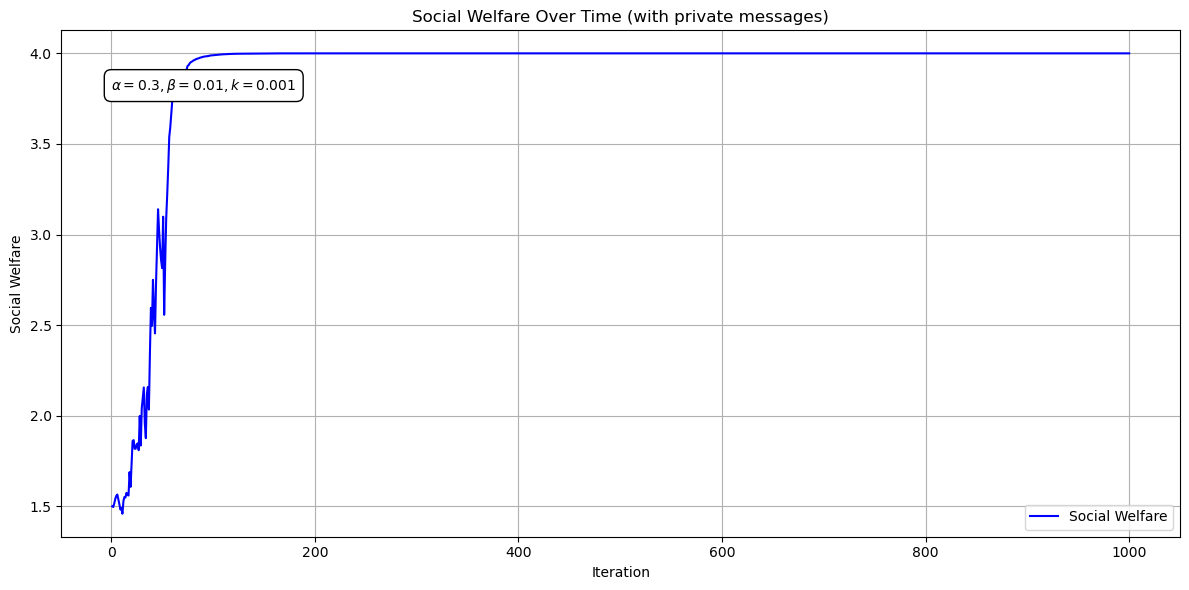

In [314]:
# social welfare over time

social_welfare_history = results["social_welfare_history"]

# Plot social welfare over time
plt.figure(figsize=(12, 6))
plt.plot(range(1, T + 1), social_welfare_history, label="Social Welfare", color="blue")
plt.title("Social Welfare Over Time (with private messages)")
plt.xlabel("Iteration")
plt.ylabel("Social Welfare")
plt.grid()
plt.legend()

plt.text(
    0, 3.8,   # Coordinates for the text box (adjust based on your plot)
    r"$\alpha = 0.3, \beta = 0.01, k = 0.001$", 
    fontsize=10, 
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5')
)

plt.tight_layout()

plt.savefig("/Users/franc/Dropbox/ML project/code/images_fra/welfare_Coordination_private_msg.png")

plt.show()


In [318]:
# avergae social welfare

average_SW = np.sum(social_welfare_history)/T
average_SW

3.8894238731847417

# benchmark with no messages

In [323]:
# Message set
messages_stand = ["m1"]

# Partitions for each player
# Player 0 groups messages into two sets: {"m1", "m2"} and {"m3", "m4"}
# Player 1 groups messages into two sets: {"m1", "m3"} and {"m2", "m4"}
partitions_stand = [
    {  # Partition for Player 0
        "group_0": {"m1"}
    },
    {  # Partition for Player 1
        "group_0": {"m1"}
    }
]

# Initial message probabilities
initial_message_probabilities_stand = [1]  # Uniform probabilities

In [325]:
# Run the Q-learning algorithm
results_stand = q_learning_with_partitions(
    payoffs, T, alpha, beta0, k, messages_stand, initial_message_probabilities_stand, social_welfare_function, partitions_stand
)

# Display results# print("Last iterate mixed strategies (by message):", results["last_iterate"])
print("Adaptive message probabilities:", results_stand["adaptive_message_probabilities"])
print("Last iterated correlated strategy:", results_stand["correlated_strategy"])
# print("Social welfare:", results["social_welfare_weighted_last"])

Adaptive message probabilities: [1.]
Last iterated correlated strategy: {(0, 0): 1.0, (0, 1): 1.0425132281612601e-29, (1, 0): 1.0425132281612601e-29, (1, 1): 1.0868338308912116e-58}


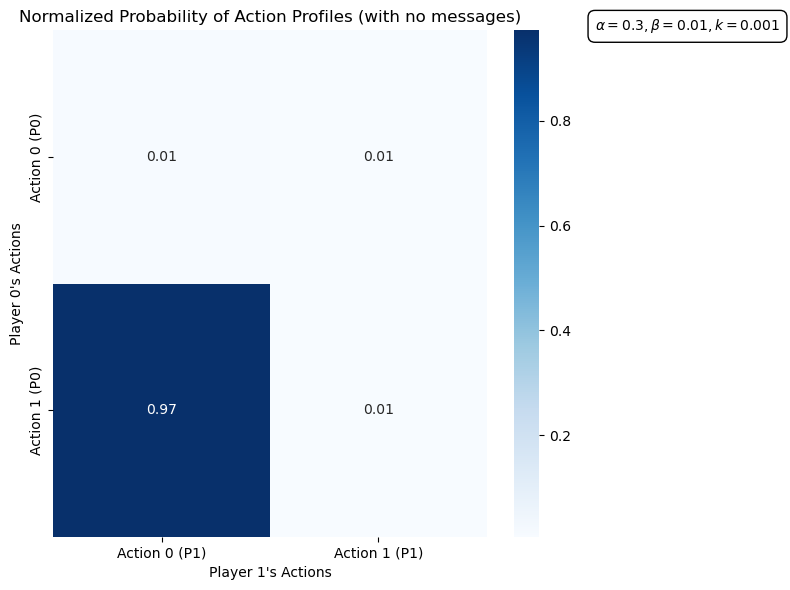

In [327]:
# Extract action history
action_history_0_stand = results_stand["action_history"][0]  # Player 0's actions
action_history_1_stand = results_stand["action_history"][1]  # Player 1's actions

# Compute the frequency matrix for action profiles [a_0, a_1]
num_actions = 2  # Assuming binary actions (0 and 1)
frequency_matrix_stand = np.zeros((num_actions, num_actions), dtype=int)

# Count occurrences of each action profile
for a0, a1 in zip(action_history_0_stand, action_history_1_stand):
    frequency_matrix_stand[a0, a1] += 1

# Normalize the frequency matrix to get probabilities
frequency_matrix_prob_stand = frequency_matrix_stand / np.sum(frequency_matrix_stand)

# Plot the normalized frequency matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    frequency_matrix_prob_stand, 
    annot=True, 
    fmt=".2f", 
    cmap="Blues", 
    xticklabels=["Action 0 (P1)", "Action 1 (P1)"],
    yticklabels=["Action 0 (P0)", "Action 1 (P0)"]
)
plt.title("Normalized Probability of Action Profiles (with no messages)")
plt.xlabel("Player 1's Actions")
plt.ylabel("Player 0's Actions")

plt.text(
    2.5, 0,   # Coordinates for the text box (adjust based on your plot)
    r"$\alpha = 0.3, \beta = 0.01, k = 0.001$", 
    fontsize=10, 
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5')
)

plt.tight_layout()

plt.savefig("/Users/franc/Dropbox/ML project/code/images_fra/frequency_Coordination_no_private_msg.png")

plt.show()

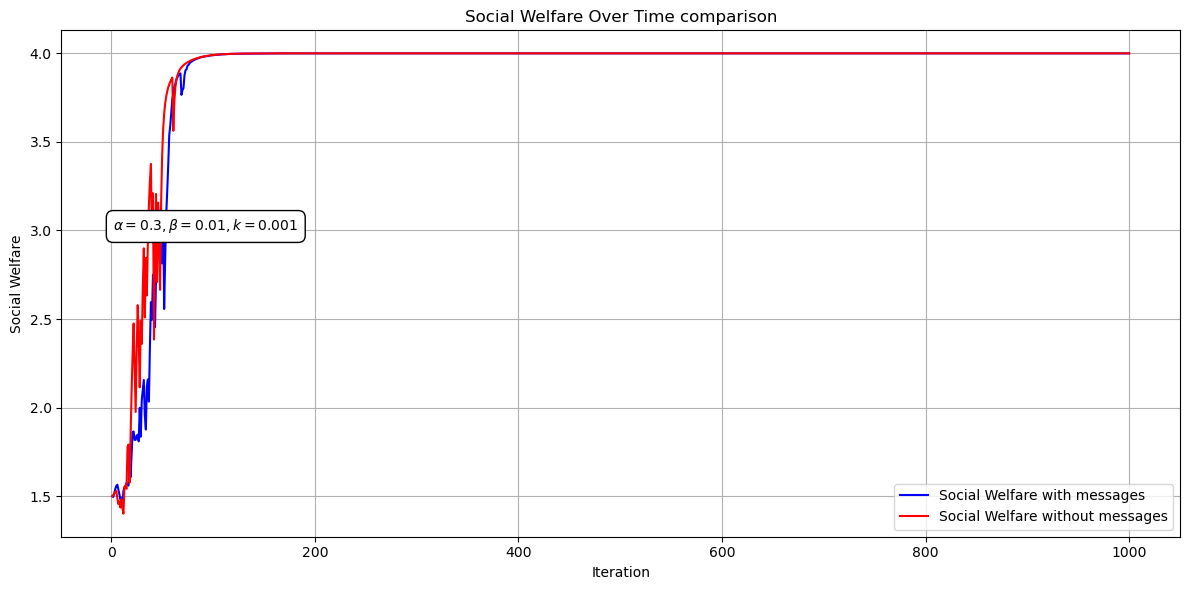

In [329]:
# social welfare over time

social_welfare_history_stand = results_stand["social_welfare_history"]

# Plot social welfare over time
plt.figure(figsize=(12, 6))
plt.plot(range(1, T + 1), social_welfare_history, label="Social Welfare with messages", color="blue")
plt.plot(range(1, T + 1), social_welfare_history_stand, label="Social Welfare without messages", color="red")
plt.title("Social Welfare Over Time comparison")
plt.xlabel("Iteration")
plt.ylabel("Social Welfare")
plt.grid()
plt.legend()

plt.text(
    2, 3,   # Coordinates for the text box (adjust based on your plot)
    r"$\alpha = 0.3, \beta = 0.01, k = 0.001$", 
    fontsize=10, 
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5')
)

plt.tight_layout()

plt.savefig("/Users/franc/Dropbox/ML project/code/images_fra/welfare_comparison_Coordination_private_msg.png")

plt.show()

In [331]:
average_SW_stand = np.sum(social_welfare_history_stand)/T
average_SW_stand

3.90873755015397

In [333]:
average_SW - average_SW_stand

-0.019313676969228144